<a href="https://colab.research.google.com/github/arnaldourbina/HACKATON_Equipo_H12-25-L-Equipo74/blob/Side-dev%2FAnalisis_Modelos%26Variables/ProyectoFoT_Analisis_flights2015_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 FlightOnTime - Predicción de Retrasos de Vuelos
## Análisis Final Data Science

**Objetivo:** Predecir retrasos de salida ≥30 min  
**Dataset:** Flight Delays 2015



In [1]:
!pip install opendatasets --quiet
!pip install imbalanced-learn --quiet
!pip install catboost --quiet

import os
import warnings
from typing import List  # si usas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## 1. DESCARGA Y CARGA DEL DATASET DESDE KAGGLE

In [2]:
import opendatasets as od

url_dataset = "https://www.kaggle.com/datasets/usdot/flight-delays"
carpeta_datos = "flight-delays"
od.download(url_dataset, carpeta_datos)

# Carga ordenada
df_flights = pd.read_csv(os.path.join("/content/flight-delays/flight-delays/flights.csv"), low_memory=False)
df_airlines = pd.read_csv(os.path.join("/content/flight-delays/flight-delays/airlines.csv"))
df_airports = pd.read_csv(os.path.join("/content/flight-delays/flight-delays/airports.csv"))

print(f"✅ Filas - Columnas cargadas! - Dataframe vuelos: ", df_flights.shape)
print(f"\n")
print("✅ Filas - Columnas cargadas! - Dataframe aeropuertos: ", df_airports.shape)
print("\n")
print("✅ Filas - Columnas cargadas! - Dataframe aerolineas: ", df_airlines.shape)

Skipping, found downloaded files in "flight-delays/flight-delays" (use force=True to force download)
✅ Filas - Columnas cargadas! - Dataframe vuelos:  (5819079, 31)


✅ Filas - Columnas cargadas! - Dataframe aeropuertos:  (322, 7)


✅ Filas - Columnas cargadas! - Dataframe aerolineas:  (14, 2)


## 2. UNION DE LOS DATOS


In [3]:
df_flights = df_flights.merge(df_airlines, left_on="AIRLINE", right_on="IATA_CODE", how="left")
df_flights = df_flights.merge(df_airports[["IATA_CODE", "STATE"]], left_on="ORIGIN_AIRPORT", right_on="IATA_CODE", how="left", suffixes=("", "_origen"))

# 2.2 FEATURES TEMPORALES
df_flights["fecha"] = pd.to_datetime(df_flights[["YEAR", "MONTH", "DAY"]])
df_flights["dia_semana"] = df_flights["fecha"].dt.dayofweek
df_flights["hora_salida"] = (df_flights["SCHEDULED_DEPARTURE"] // 100).astype(int)

def franja(h):
    return "mañana" if 6<=h<12 else "tarde" if 12<=h<18 else "noche" if 18<=h<24 else "madrugada"
df_flights["franja_horaria"] = df_flights["hora_salida"].apply(franja)

df_flights["distancia_km"] = df_flights["DISTANCE"] * 1.60934

In [4]:
df_flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE_x', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'IATA_CODE', 'AIRLINE_y',
       'IATA_CODE_origen', 'STATE', 'fecha', 'dia_semana', 'hora_salida',
       'franja_horaria', 'distancia_km'],
      dtype='object')

In [5]:
df_flights.rename(columns={'STATE_origen': 'estado_origen'}, inplace=True)

## 3. LIMPIEZA Y CREACIÓN DEL TARGET


In [6]:
columnas_eliminar = [
    'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'AIR_TIME',
    'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
    'FLIGHT_NUMBER', 'TAIL_NUMBER', 'CANCELLED', 'CANCELLATION_REASON',
    'DIVERTED', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
    'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY',
    'ELAPSED_TIME', 'SCHEDULED_TIME'
]

df_flights_limpio = df_flights.drop(columns=[col for col in columnas_eliminar if col in df_flights.columns])

df_flights_limpio.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,DISTANCE,SCHEDULED_ARRIVAL,IATA_CODE,AIRLINE_y,IATA_CODE_origen,STATE,fecha,dia_semana,hora_salida,franja_horaria,distancia_km
0,2015,1,1,4,AS,ANC,SEA,5,-11.0,1448,430,AS,Alaska Airlines Inc.,ANC,AK,2015-01-01,3,0,madrugada,2330.32432
1,2015,1,1,4,AA,LAX,PBI,10,-8.0,2330,750,AA,American Airlines Inc.,LAX,CA,2015-01-01,3,0,madrugada,3749.76220
2,2015,1,1,4,US,SFO,CLT,20,-2.0,2296,806,US,US Airways Inc.,SFO,CA,2015-01-01,3,0,madrugada,3695.04464
3,2015,1,1,4,AA,LAX,MIA,20,-5.0,2342,805,AA,American Airlines Inc.,LAX,CA,2015-01-01,3,0,madrugada,3769.07428
4,2015,1,1,4,AS,SEA,ANC,25,-1.0,1448,320,AS,Alaska Airlines Inc.,SEA,WA,2015-01-01,3,0,madrugada,2330.32432


In [7]:
# Verificación de valores nulos
valores_nulos = pd.DataFrame()
valores_nulos['Feature'] = df_flights_limpio.columns
valores_nulos['Cantidad_nulos'] = df_flights_limpio.isnull().sum().values
valores_nulos.reset_index(inplace=True, drop=True)
valores_nulos.sort_values(by='Cantidad_nulos', ascending=False, inplace=True)
valores_nulos

,Feature,Cantidad_nulos
13,IATA_CODE_origen,486165
14,STATE,486165
8,DEPARTURE_DELAY,86153
0,YEAR,0
3,DAY_OF_WEEK,0
2,DAY,0
1,MONTH,0
4,AIRLINE_x,0
7,SCHEDULED_DEPARTURE,0
9,DISTANCE,0


In [8]:
# Eliminar filas con NA en columnas críticas
columnas_info_critica = ['DEPARTURE_DELAY', 'AIRLINE', 'ORIGIN_AIRPORT',
             'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DISTANCE']
df_flights_limpio = df_flights_limpio.dropna(subset=['DEPARTURE_DELAY', 'IATA_CODE_origen', 'STATE'])


df_flights_limpio.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,DISTANCE,SCHEDULED_ARRIVAL,IATA_CODE,AIRLINE_y,IATA_CODE_origen,STATE,fecha,dia_semana,hora_salida,franja_horaria,distancia_km
0,2015,1,1,4,AS,ANC,SEA,5,-11.0,1448,430,AS,Alaska Airlines Inc.,ANC,AK,2015-01-01,3,0,madrugada,2330.32432
1,2015,1,1,4,AA,LAX,PBI,10,-8.0,2330,750,AA,American Airlines Inc.,LAX,CA,2015-01-01,3,0,madrugada,3749.76220
2,2015,1,1,4,US,SFO,CLT,20,-2.0,2296,806,US,US Airways Inc.,SFO,CA,2015-01-01,3,0,madrugada,3695.04464
3,2015,1,1,4,AA,LAX,MIA,20,-5.0,2342,805,AA,American Airlines Inc.,LAX,CA,2015-01-01,3,0,madrugada,3769.07428
4,2015,1,1,4,AS,SEA,ANC,25,-1.0,1448,320,AS,Alaska Airlines Inc.,SEA,WA,2015-01-01,3,0,madrugada,2330.32432


In [9]:
display(df_flights_limpio.head(5))
display(df_flights_limpio.columns)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,DISTANCE,SCHEDULED_ARRIVAL,IATA_CODE,AIRLINE_y,IATA_CODE_origen,STATE,fecha,dia_semana,hora_salida,franja_horaria,distancia_km
0,2015,1,1,4,AS,ANC,SEA,5,-11.0,1448,430,AS,Alaska Airlines Inc.,ANC,AK,2015-01-01,3,0,madrugada,2330.32432
1,2015,1,1,4,AA,LAX,PBI,10,-8.0,2330,750,AA,American Airlines Inc.,LAX,CA,2015-01-01,3,0,madrugada,3749.76220
2,2015,1,1,4,US,SFO,CLT,20,-2.0,2296,806,US,US Airways Inc.,SFO,CA,2015-01-01,3,0,madrugada,3695.04464
3,2015,1,1,4,AA,LAX,MIA,20,-5.0,2342,805,AA,American Airlines Inc.,LAX,CA,2015-01-01,3,0,madrugada,3769.07428
4,2015,1,1,4,AS,SEA,ANC,25,-1.0,1448,320,AS,Alaska Airlines Inc.,SEA,WA,2015-01-01,3,0,madrugada,2330.32432


Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE_x', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY',
       'DISTANCE', 'SCHEDULED_ARRIVAL', 'IATA_CODE', 'AIRLINE_y',
       'IATA_CODE_origen', 'STATE', 'fecha', 'dia_semana', 'hora_salida',
       'franja_horaria', 'distancia_km'],
      dtype='object')

In [10]:
# Verificación de valores nulos
valores_nulos = pd.DataFrame()
valores_nulos['Feature'] = df_flights_limpio.columns
valores_nulos['Cantidad_nulos'] = df_flights_limpio.isnull().sum().values
valores_nulos.reset_index(inplace=True, drop=True)
valores_nulos.sort_values(by='Cantidad_nulos', ascending=False, inplace=True)
valores_nulos

,Feature,Cantidad_nulos
0,YEAR,0
1,MONTH,0
2,DAY,0
3,DAY_OF_WEEK,0
4,AIRLINE_x,0
5,ORIGIN_AIRPORT,0
6,DESTINATION_AIRPORT,0
7,SCHEDULED_DEPARTURE,0
8,DEPARTURE_DELAY,0
9,DISTANCE,0


In [11]:
# Creación de la variable target

df_flights_limpio['target'] = (df_flights_limpio['DEPARTURE_DELAY'] >= 30).astype(int)
df_flights_limpio['target'].value_counts(normalize=True)

print("distribución del target:")
print(df_flights_limpio['target'].value_counts(normalize=True))

distribución del target:
target
0    0.881559
1    0.118441
Name: proportion, dtype: float64


## 4. ANÁLISIS EXPLORATORIO (EDA)

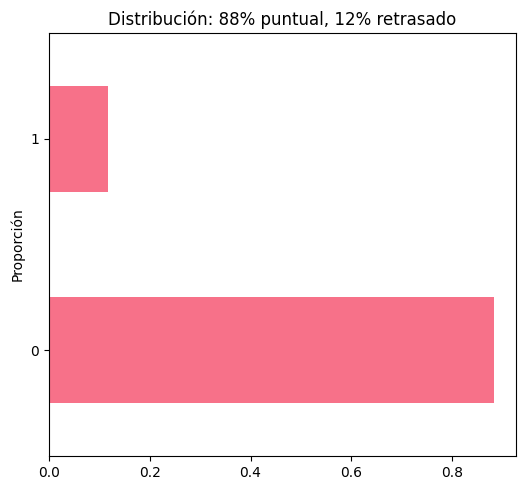

In [12]:
# Distribución del target.
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_flights_limpio['target'].value_counts(normalize=True).plot(kind='barh')
plt.title('Distribución: 88% puntual, 12% retrasado')
plt.ylabel('Proporción')
plt.tight_layout()
plt.show()

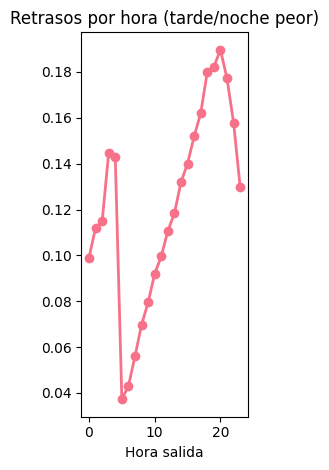

In [13]:
# Tasa por hora.
plt.subplot(1, 3, 2)
tasa_hora = df_flights_limpio.groupby('hora_salida')['target'].mean()
plt.plot(tasa_hora.index, tasa_hora.values, 'o-', linewidth=2)
plt.title('Retrasos por hora (tarde/noche peor)')
plt.xlabel('Hora salida')
plt.tight_layout()
plt.show()

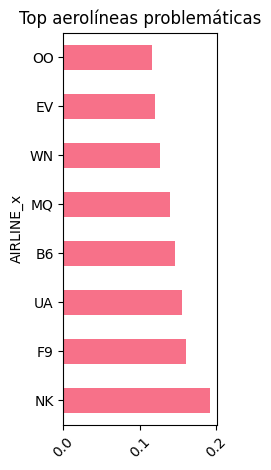

In [14]:
# TOP por aerolineas.
plt.subplot(1, 3, 3)
tasa_aero = df_flights_limpio.groupby('AIRLINE_x')['target'].mean().sort_values(ascending=False).head(8)
tasa_aero.plot(kind='barh')
plt.title('Top aerolíneas problemáticas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

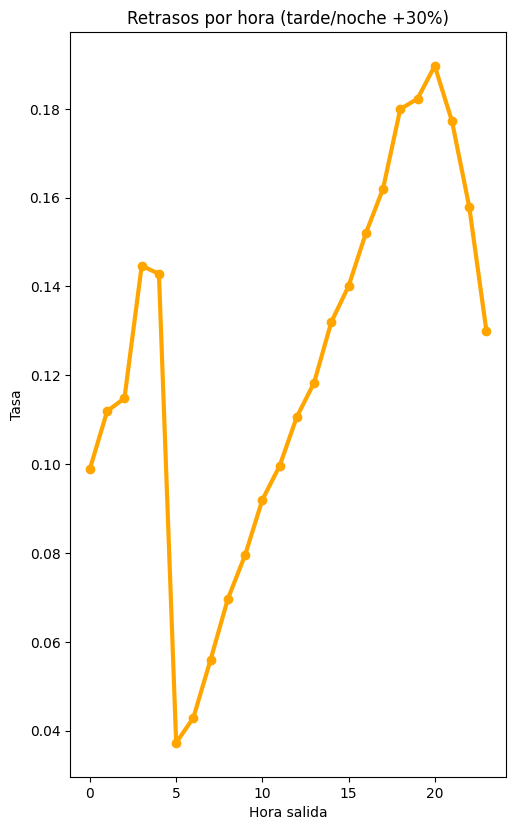

In [15]:
fig = plt.figure(figsize=(20, 16))

# 1. RETRASOS POR HORA
plt.subplot(2, 4, 2)
tasa_hora = df_flights_limpio.groupby('hora_salida')['target'].mean()
plt.plot(tasa_hora.index, tasa_hora.values, 'o-', linewidth=3, color='orange')
plt.title('Retrasos por hora (tarde/noche +30%)')
plt.xlabel('Hora salida'); plt.ylabel('Tasa')

plt.tight_layout()
plt.show()

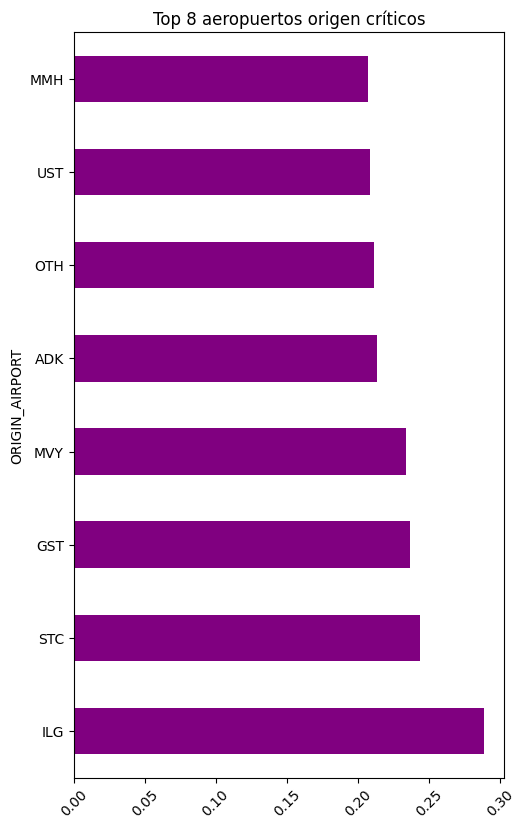

In [16]:
fig = plt.figure(figsize=(20, 16))

# 1. RETRASOS POR HORA
plt.subplot(2, 4, 4)
tasa_origen = df_flights_limpio.groupby('ORIGIN_AIRPORT')['target'].mean().sort_values(ascending=False).head(8)
tasa_origen.plot(kind='barh', color='purple')
plt.title('Top 8 aeropuertos origen críticos')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

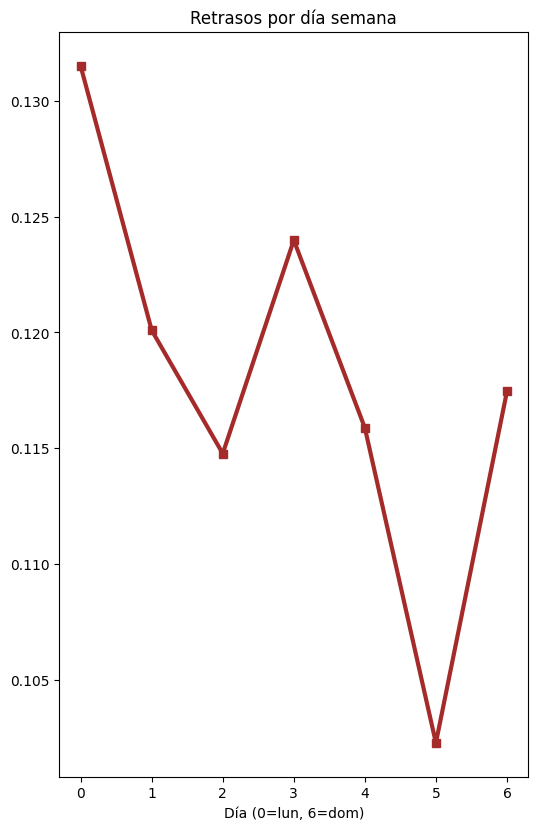

In [17]:
fig = plt.figure(figsize=(20, 16))

# 3. Retrasos por dia de semana.
plt.subplot(2, 4, 5)
tasa_dia = df_flights_limpio.groupby('dia_semana')['target'].mean()
plt.plot(tasa_dia.index, tasa_dia.values, 's-', linewidth=3, color='brown')
plt.title('Retrasos por día semana')
plt.xlabel('Día (0=lun, 6=dom)')

plt.tight_layout()
plt.show()

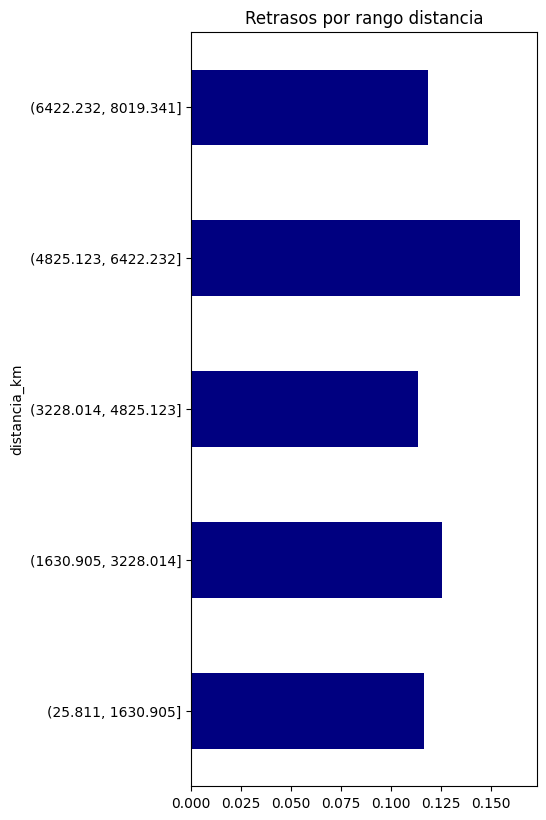

In [18]:
fig = plt.figure(figsize=(20, 16))

# 4. Retrasos por rango de distancia
plt.subplot(2, 4, 7)
bins_dist = pd.cut(df_flights_limpio['distancia_km'], bins=5)
tasa_dist = df_flights_limpio.groupby(bins_dist)['target'].mean()
tasa_dist.plot(kind='barh', color='navy')
plt.title('Retrasos por rango distancia')

plt.tight_layout()
plt.show()

# 5. Se comprime la fuente de datos.

## Se comprime la fuente de datos para efectos de rapidez en la ejecución de modelos.

In [19]:
df_limpio_acotado = df_flights_limpio.sample(n=500_000, random_state=42)
df_limpio_acotado.shape

(500000, 21)

In [20]:
df_limpio_acotado.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,DISTANCE,...,IATA_CODE,AIRLINE_y,IATA_CODE_origen,STATE,fecha,dia_semana,hora_salida,franja_horaria,distancia_km,target
4126429,2015,9,14,1,HA,OGG,HNL,1333,2.0,100,...,HA,Hawaiian Airlines Inc.,OGG,HI,2015-09-14,0,13,tarde,160.93400,0
3453047,2015,8,3,1,DL,JFK,SEA,1545,28.0,2422,...,DL,Delta Air Lines Inc.,JFK,NY,2015-08-03,0,15,tarde,3897.82148,0
2911662,2015,7,2,4,EV,ATL,CSG,1000,-1.0,83,...,EV,Atlantic Southeast Airlines,ATL,GA,2015-07-02,3,10,mañana,133.57522,0
2209405,2015,5,20,3,B6,TPA,JFK,1916,47.0,1005,...,B6,JetBlue Airways,TPA,FL,2015-05-20,2,19,noche,1617.38670,1
141934,2015,1,10,6,US,LAX,PHL,30,-3.0,2402,...,US,US Airways Inc.,LAX,CA,2015-01-10,5,0,madrugada,3865.63468,0


# 6. Definición de variables a utilizar.

## Se definen las variables mas relevantes para el proyecto y su target final.

In [21]:
columnas_finales = [
    'AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'hora_salida', 'franja_horaria', 'distancia_km',
    'MONTH', 'dia_semana']

X = df_limpio_acotado[columnas_finales].copy()
y = df_limpio_acotado['target']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Desbalanceo: {y.value_counts(normalize=True)}")

X shape: (500000, 8)
y shape: (500000,)
Desbalanceo: target
0    0.881386
1    0.118614
Name: proportion, dtype: float64


# 7. Toma de muestras para el entrenamiento de los modelos.

In [22]:
# Entrenamiento

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Train: {len(X_train):,} ({100*len(X_train)/len(X):.1f}%)")
print(f"Val:   {len(X_val):,} ({100*len(X_val)/len(X):.1f}%)")
print(f"Test:  {len(X_test):,} ({100*len(X_test)/len(X):.1f}%)")

Train: 281,250 (56.2%)
Val:   93,750 (18.8%)
Test:  125,000 (25.0%)


# 8. Creación, optimización y selección del mejor modelo.

## LIGHTGBM

In [23]:
categorical_features_lgb = ['AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'franja_horaria']
numerical_features_lgb = ['hora_salida', 'distancia_km', 'MONTH', 'dia_semana']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_lgb),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_lgb)
    ],
    remainder='passthrough'
)

pipeline_balanceado = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.75, random_state=42)),  # 75% ratio óptimo
    ('model', lgb.LGBMClassifier(
    n_estimators=450,
    learning_rate=0.025,
    num_leaves=80,
    max_depth=11,
    scale_pos_weight=7.5,
    class_weight='balanced',
    min_child_samples=120,
    subsample=0.88,
    colsample_bytree=0.85,
    reg_alpha=0.15,
    reg_lambda=0.12,
    subsample_freq=1,
    bagging_seed=42,
    feature_fraction_seed=42,
    random_state=42,
    verbose=-1,
    n_jobs=-1
    ))
])

pipeline_balanceado.fit(X_train, y_train)

y_pred = pipeline_balanceado.predict(X_test)
print("SMOTE + LightGBM:")
print(classification_report(y_test, y_pred))
print(f"Recall retrasos: {recall_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")

🎯 RESULTADOS SMOTE + LightGBM:
              precision    recall  f1-score   support

           0       0.95      0.31      0.46    110207
           1       0.15      0.89      0.25     14793

    accuracy                           0.38    125000
   macro avg       0.55      0.60      0.36    125000
weighted avg       0.86      0.38      0.44    125000

Recall retrasos: 0.887
F1-score: 0.252


# Buscando mejorar el modelo predictivo LIGHTGBM

In [24]:
lgb_balanceado = lgb.LGBMClassifier(
    n_estimators=400,
    learning_rate=0.02,
    max_depth=12,
    scale_pos_weight=7.5,  # 88/12 ≈ 7.5
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

lgb_balanceado.fit(X_train_processed, y_train)
y_pred_lgb = lgb_balanceado.predict(X_test_processed)

print("LightGBM nativo:")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.3f}")
print(f"F1: {f1_score(y_test, y_pred_lgb):.3f}")

LightGBM nativo:
Recall: 0.998
F1: 0.213


In [25]:
lgb_base = lgb.LGBMClassifier(random_state=42, verbose=-1)

X_train_processed_base = preprocessor.transform(X_train)
X_test_processed_base = preprocessor.transform(X_test)

lgb_base.fit(X_train_processed_base, y_train)
y_pred_base = lgb_base.predict(X_test_processed_base)

resultados = pd.DataFrame({
    'Baseline': [f1_score(y_test, y_pred_base)],
    'LightGBM nativo': [f1_score(y_test, y_pred_lgb)],
    'SMOTE + LightGBM': [f1_score(y_test, y_pred)]
}, index=['F1-score']).round(3)

print("COMPARACIÓN F1:")
print(resultados)

COMPARACIÓN F1:
          Baseline  LightGBM nativo  SMOTE + LightGBM
F1-score     0.001            0.213             0.252


In [26]:
pipeline_balanceado.fit(X_train, y_train)
y_pred = pipeline_balanceado.predict(X_test)

borderline_smote_model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('border_smote', BorderlineSMOTE(
        sampling_strategy=0.75,
        random_state=42,
        kind='borderline-1'
    )),
    ('model', lgb.LGBMClassifier(
    n_estimators=450,
    learning_rate=0.025,
    num_leaves=80,
    max_depth=11,
    scale_pos_weight=7.5,
    class_weight='balanced',
    min_child_samples=120,
    subsample=0.88,
    colsample_bytree=0.85,
    reg_alpha=0.15,
    reg_lambda=0.12,
    subsample_freq=1,
    bagging_seed=42,
    feature_fraction_seed=42,
    random_state=42,
    verbose=-1,
    n_jobs=-1
    ))
])

borderline_smote_model.fit(X_train, y_train)
y_pred_border = borderline_smote_model.predict(X_test)

print("Borderline-SMOTE + LightGBM:")
print(classification_report(y_test, y_pred_border))
print(f"F1: {f1_score(y_test, y_pred_border):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_border):.3f}")

Borderline-SMOTE + LightGBM:
              precision    recall  f1-score   support

           0       0.95      0.33      0.49    110207
           1       0.15      0.88      0.26     14793

    accuracy                           0.40    125000
   macro avg       0.55      0.60      0.37    125000
weighted avg       0.86      0.40      0.46    125000

F1: 0.255
Recall: 0.875


## CatBoost

In [27]:
numerical_features_cb = ['hora_salida', 'distancia_km', 'MONTH', 'dia_semana']
categorical_features_cb = ['AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'franja_horaria']

preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_cb),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_cb)
    ],
    remainder='passthrough'
)

catboost_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.08,
    depth=7,
    scale_pos_weight=8.0,
    random_seed=42,
    thread_count=-1,
    verbose=False
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

pipeline_catboost = ImbPipeline([
    ('preprocessor', preprocessor_catboost),
    ('smote', BorderlineSMOTE(sampling_strategy=0.75, random_state=42)),
    ('model', catboost_model)
])

pipeline_catboost.fit(X_train, y_train)
print("CatBoost:")
print(f"F1: {f1_score(y_test, pipeline_catboost.predict(X_test)):.3f}")

CatBoost:
F1: 0.256


# Buscando mejorar CATBOOST

In [28]:
numerical_features_cb = ['hora_salida','distancia_km','MONTH','dia_semana']
categorical_features_cb = ['AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'franja_horaria']

catboost_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='Logloss',
    min_data_in_leaf=200,
    border_count=254,
    scale_pos_weight=3.0,
    l2_leaf_reg=8,
    random_seed=42,
    early_stopping_rounds=100,
    thread_count=-1,
    verbose=200
)

catboost_model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_cb,
    eval_set=(X_test, y_test),
    use_best_model=True
)

y_proba = catboost_model.predict_proba(X_test)[:, 1]

for t in [0.30, 0.35, 0.40, 0.45]:
    y_pred = (y_proba >= t).astype(int)
    print(
        f"t={t:.2f} | Recall={recall_score(y_test, y_pred):.3f} "
        f"| F1={f1_score(y_test, y_pred):.3f} "
        f"| %pos={(y_pred==1).mean():.2f}"
    )

0:	learn: 0.6817223	test: 0.6816708	best: 0.6816708 (0)	total: 333ms	remaining: 4m 26s
200:	learn: 0.5530574	test: 0.5570577	best: 0.5570577 (200)	total: 1m 52s	remaining: 5m 35s
400:	learn: 0.5406063	test: 0.5536351	best: 0.5536351 (400)	total: 3m 55s	remaining: 3m 54s
600:	learn: 0.5314012	test: 0.5527505	best: 0.5527406 (580)	total: 5m 49s	remaining: 1m 55s
799:	learn: 0.5231245	test: 0.5524678	best: 0.5524666 (798)	total: 7m 46s	remaining: 0us

bestTest = 0.5524666333
bestIteration = 798

Shrink model to first 799 iterations.
t=0.30 | Recall=0.624 | F1=0.296 | %pos=0.38
t=0.35 | Recall=0.487 | F1=0.301 | %pos=0.26
t=0.40 | Recall=0.357 | F1=0.293 | %pos=0.17
t=0.45 | Recall=0.233 | F1=0.255 | %pos=0.10


## XGBOOST

In [29]:
numerical_features_xgb = ['hora_salida', 'distancia_km', 'MONTH', 'dia_semana']
categorical_features_xgb = ['AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'franja_horaria']

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_xgb),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_xgb)
    ],
    remainder='passthrough'
)

pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor_xgb),
    ('smote', BorderlineSMOTE(sampling_strategy=0.75, random_state=42)),
    ('model', xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.08,
        max_depth=8,
        scale_pos_weight=8.0,
        n_jobs=-1,
        random_state=42,
        verbosity=0
    ))
])

pipeline_xgb.fit(X_train, y_train)
print("XGBoost:")
print(f"F1: {f1_score(y_test, pipeline_xgb.predict(X_test)):.3f}")

XGBoost:
F1: 0.249


## Random Forest

In [30]:
numerical_features_rf = ['hora_salida', 'distancia_km', 'MONTH', 'dia_semana']
categorical_features_rf = ['AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'franja_horaria']

preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_rf),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_rf)
    ],
    remainder='passthrough'
)

pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor_rf),
    ('smote', BorderlineSMOTE(sampling_strategy=0.75, random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_split=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_rf.fit(X_train, y_train)
print("Random Forest:")
print(f"F1: {f1_score(y_test, pipeline_rf.predict(X_test)):.3f}")

Random Forest:
F1: 0.272


## Regresión logistica.

In [31]:
numerical_features_logreg = ['hora_salida', 'distancia_km', 'MONTH', 'dia_semana']
categorical_features_logreg = ['AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'franja_horaria']

preprocessor_logreg = ColumnTransformer([
    ('num', StandardScaler(), numerical_features_logreg),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
     categorical_features_logreg)
])

pipeline_logreg = ImbPipeline([
    ('preprocess', preprocessor_logreg),
    ('smote', BorderlineSMOTE(sampling_strategy=0.75, random_state=42)),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

pipeline_logreg.fit(X_train, y_train)
print("Logistic Regression:")
print(f"F1: {f1_score(y_test, pipeline_logreg.predict(X_test)):.3f}")

Logistic Regression:
F1: 0.275


# Creación función imprime reportes.

In [32]:
def evaluar_modelo(modelo, nombre, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    print(f"\n{'='*60}")
    print(f"{nombre.upper()}")
    print('='*60)
    print(classification_report(y_test, y_pred))
    print(f"Recall retrasos: {recall_score(y_test, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("-"*60)

    return {
        'nombre': nombre,
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred)
    }

In [33]:
resultado_lgb = evaluar_modelo(pipeline_balanceado, "LightGBM balanceado", X_test, y_test)


LIGHTGBM BALANCEADO
              precision    recall  f1-score   support

           0       0.95      0.31      0.46    110207
           1       0.15      0.89      0.25     14793

    accuracy                           0.38    125000
   macro avg       0.55      0.60      0.36    125000
weighted avg       0.86      0.38      0.44    125000

Recall retrasos: 0.887
F1-score: 0.252
Accuracy: 0.376
------------------------------------------------------------


In [34]:
resultado_lgb = evaluar_modelo(borderline_smote_model, "LightGBM Optimizado", X_test, y_test)


LIGHTGBM OPTIMIZADO
              precision    recall  f1-score   support

           0       0.95      0.33      0.49    110207
           1       0.15      0.88      0.26     14793

    accuracy                           0.40    125000
   macro avg       0.55      0.60      0.37    125000
weighted avg       0.86      0.40      0.46    125000

Recall retrasos: 0.875
F1-score: 0.255
Accuracy: 0.395
------------------------------------------------------------


In [35]:
resultado_cat = evaluar_modelo(pipeline_catboost, "CatBoost", X_test, y_test)


CATBOOST
              precision    recall  f1-score   support

           0       0.95      0.35      0.51    110207
           1       0.15      0.86      0.26     14793

    accuracy                           0.41    125000
   macro avg       0.55      0.60      0.38    125000
weighted avg       0.85      0.41      0.48    125000

Recall retrasos: 0.860
F1-score: 0.256
Accuracy: 0.409
------------------------------------------------------------


In [36]:
resultado_xgb = evaluar_modelo(pipeline_xgb, "XGBoost", X_test, y_test)


XGBOOST
              precision    recall  f1-score   support

           0       0.95      0.29      0.45    110207
           1       0.14      0.89      0.25     14793

    accuracy                           0.36    125000
   macro avg       0.55      0.59      0.35    125000
weighted avg       0.86      0.36      0.42    125000

Recall retrasos: 0.891
F1-score: 0.249
Accuracy: 0.362
------------------------------------------------------------


In [37]:
resultado_rf = evaluar_modelo(pipeline_rf, "Random Forest", X_test, y_test)



RANDOM FOREST
              precision    recall  f1-score   support

           0       0.92      0.59      0.72    110207
           1       0.17      0.64      0.27     14793

    accuracy                           0.60    125000
   macro avg       0.55      0.61      0.50    125000
weighted avg       0.83      0.60      0.67    125000

Recall retrasos: 0.635
F1-score: 0.272
Accuracy: 0.597
------------------------------------------------------------


In [38]:
resultado_log = evaluar_modelo(pipeline_logreg, "Logistic Regression", X_test, y_test)



LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.92      0.61      0.74    110207
           1       0.18      0.62      0.27     14793

    accuracy                           0.61    125000
   macro avg       0.55      0.62      0.51    125000
weighted avg       0.83      0.61      0.68    125000

Recall retrasos: 0.619
F1-score: 0.275
Accuracy: 0.613
------------------------------------------------------------


# Selección del modelo final y demo de prueba.

In [39]:
modelo_final = {
    'modelo': borderline_smote_model,
    'features': X_train.columns.tolist(),
    'metrics': {
        'f1': f1_score(y_test, borderline_smote_model.predict(X_test)),
        'recall': recall_score(y_test, borderline_smote_model.predict(X_test))
    },
    'target': '>=30min',
    'version': '1.0'
}

joblib.dump(modelo_final, 'modelo_predictivo_FoT.joblib')

# Test carga
test_modelo = joblib.load('modelo_predictivo_FoT.joblib')
print(f"Modelo listo: F1 {modelo_final['metrics']['f1']:.3f}")

Modelo listo: F1 0.255


# Función predicción de vuelos

In [40]:
def predecir_vuelo(AIRLINE_x, ORIGIN_AIRPORT, DESTINATION_AIRPORT, fecha_partida, distancia_km):
    fecha = pd.to_datetime(fecha_partida)
    hora_salida = fecha.hour
    dia_semana_numeric = fecha.dayofweek # 0 for Monday, 6 for Sunday
    month = fecha.month
    day_of_week_model_feature = fecha.dayofweek + 1 # Model expects 1-7 for day of week

    def franja(h):
        return "mañana" if 6 <= h < 12 else "tarde" if 12 <= h < 18 else "noche" if 18 <= h < 24 else "madrugada"
    franja_horaria_value = franja(hora_salida)

    data_dict = {
        "AIRLINE_x": [AIRLINE_x],
        "ORIGIN_AIRPORT": [ORIGIN_AIRPORT],
        "DESTINATION_AIRPORT": [DESTINATION_AIRPORT],
        "hora_salida": [hora_salida],
        "franja_horaria": [franja_horaria_value],
        "distancia_km": [distancia_km],
        "MONTH": [month],
        "dia_semana": [dia_semana_numeric],
        "DAY_OF_WEEK": [day_of_week_model_feature],
    }

    df_input = pd.DataFrame(data_dict)
    df_input = df_input[modelo_final['features']]

    model_pipeline_object = modelo_final['modelo']
    proba_retraso = model_pipeline_object.predict_proba(df_input)[:, 1][0]
    pred_clase = "Retrasado" if proba_retraso >= 0.3 else "Puntual"

    return {
        "prediccion": pred_clase,
        "probabilidad": float(round(proba_retraso, 2)),
    }


resultado = predecir_vuelo(
    "AS",
    "ANC",
    "SEA",
    "2015-01-01T00:05:00",
    7852 * 1.60934,
)
print(resultado)

{'prediccion': 'Retrasado', 'probabilidad': 0.35}
